# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Business Analytics</font>

# <font color='blue'>Capítulo 10 - Financial Analytics</font>
## <font color='blue'>Mini-Projeto 1</font>
### <font color='blue'>AI Bot Trader - Robô Investidor Para Recomendação de Compra e Venda de Criptomoedas</font>

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.8.11


![title](imagens/mini-projeto1.png)

## Avisos Antes de Começar

- 1- Nosso objetivo aqui é didático! Não use essa aplicação para fins comerciais sem antes realizar muitos testes.
- 2- A execução do processo de treinamento pode ser bastante demorada dependendo do hardware do seu computador.
- 3- Experimente a aplicação com outras técnicas.
- 4- Este projeto é completo e funcional, mas uma versão mais avançada pode ser encontrada no curso de IA Para Finanças da Formação Engenheiro Blockchain.
- 5- Se executar muitas vezes seguidas este projeto seu acesso à API pode ser bloqueado. Estamos fornecendo o arquivo de dados extraídos no dia da gravação das aulas.

## Definição do Problema e Fonte de Dados

Leia o manual em pdf no Capítulo 10.

## Etapas do Projeto

- Parte 1 - Extração dos Dados em Tempo Real
- Parte 2 - Análise de Dados
- Parte 3 - Construção do Modelo e Otimização Bayesiana
- Parte 4 - Execução do AI Bot Trader
- Parte 5 - Conclusão e Próximos Passos

## Instalando e Carregando os Pacotes

In [2]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [3]:
# CryptoCurrency eXchange Trading Library
# https://pypi.org/project/ccxt/
!pip install -q ccxt

In [4]:
# https://pypi.org/project/bayesian-optimization/
!pip install -q bayesian-optimization 

In [5]:
# Imports
import csv
import ccxt
import time
import random
import types
import pkg_resources
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bayes_opt import BayesianOptimization
from pprint import pprint
from datetime import datetime
sns.set()

In [6]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

seaborn   : 0.11.2
matplotlib: 3.4.2
numpy     : 1.20.3
pandas    : 1.3.2
csv       : 1.0
ccxt      : 1.56.60



## Parte 1 - Extração dos Dados em Tempo Real

### Função de Gravação dos Dados

In [7]:
# Função para salvar dados em formato csv
def grava_csv(arquivo, dados):
    
    # Abre o arquivo para escrita
    with open(arquivo, mode = 'w') as arquivo_saida:
        
        # Gera o cabeçalho
        arquivo_saida.write("Date,Open,High,Low,Close,Adj Close,Volume\n")
        
        # Grava os dados
        csv_writer = csv.writer(arquivo_saida, delimiter = ',', quotechar = '"', quoting = csv.QUOTE_MINIMAL)
        csv_writer.writerows(dados)

### Função de Conexão à Operadora de Criptomoeda

In [8]:
# Função para fazer conexão à exchange para extração dos dados
# https://www.bitmex.com/
# https://www.bitmex.com/app/apiOverview
def conecta_exchange(exchange, max_retries, symbol, timeframe, since, limit):
    
    # Zera o número de tentativas
    num_retries = 0
    
    # Tenta fazer a conexão
    try:
        num_retries += 1
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since)
        return ohlcv
    except Exception:
        if num_retries > max_retries:
            raise

### Funções Para Extração dos Dados

In [9]:
# Função para extração dos dados
def extrai_dados(exchange, max_retries, symbol, timeframe, since, limit):
    
    # Timestamp
    earliest_timestamp = exchange.milliseconds()
    
    # Duração da janela em segundos
    timeframe_duration_in_seconds = exchange.parse_timeframe(timeframe)
    
    # Duração da janela em milisegundos
    timeframe_duration_in_ms = timeframe_duration_in_seconds * 1000
    
    # Diferença de tempo
    timedelta = limit * timeframe_duration_in_ms
    
    # Lista para os dados
    all_ohlcv = []
    
    # Loop
    while True:
        
        # Data de início para extração dos dados
        fetch_since = earliest_timestamp - timedelta
        
        # Conecta na exchange e extrai os dados
        ohlcv = conecta_exchange(exchange, max_retries, symbol, timeframe, fetch_since, limit)
        
        # Se alcançamos o limite, finaliza o loop
        if ohlcv[0][0] >= earliest_timestamp:
            break
        
        # Atualiza o tempo mais cedo
        earliest_timestamp = ohlcv[0][0]
        
        # Atualiza os dados
        all_ohlcv = ohlcv + all_ohlcv
        
        # Print do andamento
        print(len(all_ohlcv), 'registros extraídos de', exchange.iso8601(all_ohlcv[0][0]), 'a', exchange.iso8601(all_ohlcv[-1][0]))
        
        if fetch_since < since:
            break
            
    return all_ohlcv

In [10]:
# Função para extrair os dados e salvar em formato csv
def extrai_dados_para_csv(filename, exchange_id, max_retries, symbol, timeframe, since, limit):
    
    # Obtém o id da exchange com o pacote ccxt
    exchange = getattr(ccxt, exchange_id)({'enableRateLimit': True,})
    
    # Checa a consistência 
    if isinstance(since, str):
        since = exchange.parse8601(since)
    
    # Extrai o que está sendo comercializado
    exchange.load_markets()
    
    # Extrai os dados
    ohlcv = extrai_dados(exchange, max_retries, symbol, timeframe, since, limit)
    
    # Contador
    key = 0
    
    # Loop
    for item in ohlcv:
        epoch = int(item[0]) / 1000
        ohlcv[key][0] = datetime.utcfromtimestamp(epoch).strftime('%Y-%m-%d')
        ohlcv[key][5] = int(item[5])
        ohlcv[key].append(ohlcv[key][5])
        ohlcv[key][5] = ohlcv[key][4]
        key += 1
    
    # Comprimento de dados extraídos
    ohlen = len(ohlcv)
    
    # Print do andamento
    pprint("Número de Registros: " + str(ohlen))
    
    # Vamos manter um limite para os dados
    if ohlen > 399:
        ohrem = ohlen - 399
        pprint("Removendo: " + str(ohrem))
        ohlcv = ohlcv[ohrem:]
        
    # Grava os dados em csv
    grava_csv(filename, ohlcv)
    
    # Print
    print('Salvos', len(ohlcv), 'registros no arquivo', filename)

### Parâmetros Para Extração dos Dados

In [11]:
# Define os parâmetros de extração dos dados

# Exchange: https://www.bitmex.com/app/apiOverview
exchange = "bitmex"

# Símbolo da criptomoeda
simbolo = "BTC/USD"

# Janela
janela = "1d"

# Data de início
data_inicio = "2018-01-01T00:00:00Z"

# Arquivo de saída
outfile = "dados/dataset.csv"

### Extração dos Dados

In [12]:
# Executa a extração dos dados -- para não ficar chamando a API
if False:
    extrai_dados_para_csv(outfile, exchange, 3, simbolo, janela, data_inicio, 100)

100 registros extraídos de 2021-06-12T00:00:00.000Z a 2021-09-19T00:00:00.000Z
200 registros extraídos de 2021-03-04T00:00:00.000Z a 2021-09-19T00:00:00.000Z
300 registros extraídos de 2020-11-24T00:00:00.000Z a 2021-09-19T00:00:00.000Z
400 registros extraídos de 2020-08-16T00:00:00.000Z a 2021-09-19T00:00:00.000Z
500 registros extraídos de 2020-05-08T00:00:00.000Z a 2021-09-19T00:00:00.000Z
600 registros extraídos de 2020-01-29T00:00:00.000Z a 2021-09-19T00:00:00.000Z
700 registros extraídos de 2019-10-21T00:00:00.000Z a 2021-09-19T00:00:00.000Z
800 registros extraídos de 2019-07-13T00:00:00.000Z a 2021-09-19T00:00:00.000Z
900 registros extraídos de 2019-04-04T00:00:00.000Z a 2021-09-19T00:00:00.000Z
1000 registros extraídos de 2018-12-25T00:00:00.000Z a 2021-09-19T00:00:00.000Z
1100 registros extraídos de 2018-09-16T00:00:00.000Z a 2021-09-19T00:00:00.000Z
1200 registros extraídos de 2018-06-08T00:00:00.000Z a 2021-09-19T00:00:00.000Z
1300 registros extraídos de 2018-02-28T00:00:00.0

## Parte 2 - Análise de Dados

### Carregando e Explorando o Arquivo de Dados

In [13]:
# Carregando o arquivo do disco
df = pd.read_csv(outfile)

In [14]:
# Dados
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-20,8700.5,8739.0,8516.0,8632.5,8632.5,2016471911
1,2020-01-21,8632.5,8772.5,8455.0,8727.5,8727.5,1797763495
2,2020-01-22,8727.5,8796.5,8552.0,8664.5,8664.5,1313340524
3,2020-01-23,8664.5,8669.5,8283.5,8392.0,8392.0,2892720411
4,2020-01-24,8392.0,8515.0,8223.5,8425.5,8425.5,2520283967


In [15]:
# Shape
df.shape

(399, 7)

In [16]:
# Dados de fechamento
close = df.Close.values.tolist()

In [17]:
# Outros parâmetros para a versão base do modelo
window_size = 30
skip = 5
l = len(close) - 1

## Parte 3 - Construção do Modelo e Otimização Bayesiana

A parte 3 considera que você tem algum conhecimento em Aprendizado Por Reforço. Esse conhecimento pode ser obtido no curso de Deep Learning II em nível avançado ou em nível básico no curso gratuito de Python Fundamentos aqui na DSA.

### Estratégia de Treinamento

https://arxiv.org/abs/1712.06560

https://openai.com/blog/evolution-strategies/

https://gist.github.com/karpathy/77fbb6a8dac5395f1b73e7a89300318d

http://www.deeplearningbook.com.br/

In [18]:
# Classe para a estratégia de treinamento
# Usamos Deep Evolution Strategy do OpenAI
class PoliticaTrader:

    # Inputs
    inputs = None

    # Construtor
    def __init__(self, weights, reward_function, population_size, sigma, learning_rate):
        
        # Inicializa os atributos da classe
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    # Obtém o peso a partir da população
    def get_weights_population(self, weights, population):
        
        # Lista para os pesos
        weights_population = []
        
        # Loop pela população
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        
        return weights_population

    # Obtém os pesos
    def get_weights(self):
        return self.weights

    # Treinamento
    def treinamento(self, epoch = 100, print_every = 1):
        
        # Time
        lasttime = time.time()
        
        # Loop pelas épocas
        for i in range(epoch):
            
            # Lista para a população
            population = []
            
            # Recompensas
            rewards = np.zeros(self.population_size)
            
            # Loop pelo population_size
            for k in range(self.population_size):
                
                x = []
                
                # Loop
                for w in self.weights:
                    x.append(np.random.randn(*w.shape))
                    
                population.append(x)
            
            # Loop
            for k in range(self.population_size):
                
                weights_population = self.get_weights_population(self.weights, population[k])
                rewards[k] = self.reward_function(weights_population)
            
            # Recompensas
            rewards = (rewards - np.mean(rewards)) / np.std(rewards)
            
            # Loop
            for index, w in enumerate(self.weights):
                A = np.array([p[index] for p in population])
                
                # Pesos da rede neural 
                self.weights[index] = (w + self.learning_rate / (self.population_size * self.sigma) * np.dot(A.T, rewards).T)
            
            if (i + 1) % print_every == 0:
                print('Iteração %d. Recompensa: %f' % (i + 1, self.reward_function(self.weights)))
        
        print('Tempo Total de Treinamento:', time.time() - lasttime, 'segundos')

### Arquitetura do Modelo de Rede Neural

In [19]:
# Classe do Modelo
class Modelo:
    
    # Método construtor
    def __init__(self, input_size, layer_size, output_size):
        
        self.weights = [np.random.randn(input_size, layer_size),
                        np.random.randn(layer_size, output_size),
                        np.random.randn(layer_size, 1),
                        np.random.randn(1, layer_size),]

    # Função para previsão
    def predict(self, inputs):
        
        # Feed forward
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        
        # Decisão de compra (previsão)
        decision = np.dot(feed, self.weights[1])
        
        # Compra (decisão)
        buy = np.dot(feed, self.weights[2])
        
        return decision, buy

    def get_weights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

### Configuração do AI Bot Trader

In [20]:
# Função para obter o estado dos dados
def get_state(data, t, n):
    d = t - n + 1
    block = data[d : t + 1] if d >= 0 else -d * [data[0]] + data[0 : t + 1]
    res = []
    for i in range(n - 1):
        res.append(block[i + 1] - block[i])
    return np.array([res])

In [21]:
# Classe para o agente inteligente (Trader)
class Trader:
    
    # Método construtor
    def __init__(self, population_size, sigma, learning_rate, model, money, max_buy, max_sell, skip, window_size,):
        
        # Inicializa os atributos
        self.window_size = window_size
        self.skip = skip
        self.POPULATION_SIZE = population_size
        self.SIGMA = sigma
        self.LEARNING_RATE = learning_rate
        self.model = model
        self.initial_money = money
        self.max_buy = max_buy
        self.max_sell = max_sell
        self.es = PoliticaTrader(self.model.get_weights(),
                                 self.get_reward,
                                 self.POPULATION_SIZE,
                                 self.SIGMA,
                                 self.LEARNING_RATE,)

    # Método de ação
    def agir(self, sequence):
        decision, buy = self.model.predict(np.array(sequence))
        return np.argmax(decision[0]), int(buy[0])

    # Método para obter recompensa
    def get_reward(self, weights):
        
        # Valor inicial investido
        initial_money = self.initial_money
        starting_money = initial_money
        
        # Pesos
        self.model.weights = weights
        
        # Estado
        state = get_state(close, 0, self.window_size + 1)
        
        # Objetos de controle
        inventory = []
        quantity = 0
        
        # Loop
        for t in range(0, l, self.skip):
            
            # Ação e compra/venda
            action, buy = self.agir(state)
            
            # Próximo estado
            next_state = get_state(close, t + 1, self.window_size + 1)
            
            # Verifica ação e valor inicial investido
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                    
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
            
            elif action == 2 and len(inventory) > 0:
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                    
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell

            # Próximo estado
            state = next_state
        
        return ((initial_money - starting_money) / starting_money) * 100

    # Treinamento do Trader
    def fit(self, iterations, checkpoint):
        self.es.treinamento(iterations, print_every = checkpoint)

    # Método para recomendação
    def investir(self):
        
        # Valor inicial
        initial_money = self.initial_money
        starting_money = initial_money
        
        # Estado
        state = get_state(close, 0, self.window_size + 1)
        
        # Listas de controle        
        states_sell = []
        states_buy = []
        inventory = []
        quantity = 0
        
        # Loop
        for t in range(0, l, self.skip):
            
            # Ação e compra
            action, buy = self.agir(state)
            
            # Próximo estado
            next_state = get_state(close, t + 1, self.window_size + 1)
            
            # Verifica ação e valor inicial investido
            if action == 1 and initial_money >= close[t]:
                if buy < 0:
                    buy = 1
                if buy > self.max_buy:
                    buy_units = self.max_buy
                else:
                    buy_units = buy
                
                total_buy = buy_units * close[t]
                initial_money -= total_buy
                inventory.append(total_buy)
                quantity += buy_units
                states_buy.append(t)
                
                print('Dia %d: comprar %d unidades ao preço de %f, saldo total %f' % (t, buy_units, total_buy, initial_money))
            
            elif action == 2 and len(inventory) > 0:
                bought_price = inventory.pop(0)
                if quantity > self.max_sell:
                    sell_units = self.max_sell
                else:
                    sell_units = quantity
                if sell_units < 1:
                    continue
                    
                quantity -= sell_units
                total_sell = sell_units * close[t]
                initial_money += total_sell
                states_sell.append(t)
                
                try:
                    invest = ((total_sell - bought_price) / bought_price) * 100
                except:
                    invest = 0
                
                print('Dia %d, vender %d unidades ao preço de %f, investimento %f %%, saldo total %f,' % (t, sell_units, total_sell, invest, initial_money))
            
            # Próximo estado
            state = next_state

        # Investimento
        invest = ((initial_money - starting_money) / starting_money) * 100
        
        print('\nGanho Total %f, Valor Total Investido %f' % (initial_money - starting_money, invest))
        
        plt.figure(figsize = (20, 10))
        plt.plot(close, label = 'Valor Real de Fechamento', c = 'g')
        plt.plot(close, 'X', label = 'Previsão de Compra', markevery = states_buy, c = 'b')
        plt.plot(close, 'o', label = 'Previsão de Venda', markevery = states_sell, c = 'r')
        plt.legend()
        plt.show()

### Funções Para Buscar o Melhor Trader

In [22]:
# Função para encontrar o melhor trader
def melhor_trader(window_size, skip, population_size, sigma, learning_rate, size_network):
    
    # Cria o modelo
    model = Modelo(window_size, size_network, 3)
    
    # Cria o trader
    trader = Trader(population_size, sigma, learning_rate, model, 10000, 5, 5, skip, window_size,)
    
    # Treinamento
    try:
        trader.fit(100, 1000)
        return trader.es.reward_function(trader.es.weights)
    except:
        return 0

In [23]:
# Função para encontrar o melhor trader de acordo com os hiperparâmetros
def busca_melhor_trader(window_size, skip, population_size, sigma, learning_rate, size_network):
    
    # Variável global
    global accbest
    
    # Hiperparâmetros
    param = {'window_size': int(np.around(window_size)),
             'skip': int(np.around(skip)),
             'population_size': int(np.around(population_size)),
             'sigma': max(min(sigma, 1), 0.0001),
             'learning_rate': max(min(learning_rate, 0.5), 0.000001),
             'size_network': int(np.around(size_network)),}
    
    print('\nBuscando Parâmetros %s' % (param))
    
    # Investimento feito pelo melhor trader
    investment = melhor_trader(**param)
    
    print('Após 100 iterações o investimento foi de %f' % (investment))
        
    return investment

### Otimização Bayesiana Para os Hiperparâmetros do Modelo

In [24]:
# Modelo para otimização bayesiana de hiperparâmetros
otimizacao_bayesiana = BayesianOptimization(busca_melhor_trader, {'window_size': (2, 50),
                                                                  'skip': (1, 15),
                                                                  'population_size': (1, 50),
                                                                  'sigma': (0.01, 0.99),
                                                                  'learning_rate': (0.000001, 0.49),
                                                                  'size_network': (10, 1000),},)

In [25]:
%%time
otimizacao_bayesiana.maximize(init_points = 30, n_iter = 50, acq = 'ei', xi = 0.0)

|   iter    |  target   | learni... | popula... |   sigma   | size_n... |   skip    | window... |
-------------------------------------------------------------------------------------------------

Buscando Parâmetros {'window_size': 30, 'skip': 13, 'population_size': 27, 'sigma': 0.5439188142351072, 'learning_rate': 0.43568988239745127, 'size_network': 993}
Tempo Total de Treinamento: 6.910707235336304 segundos
Após 100 iterações o investimento foi de 2406.420000
|  1        |  2.406e+0 |  0.4357   |  27.24    |  0.5439   |  993.1    |  12.62    |  30.31    |

Buscando Parâmetros {'window_size': 24, 'skip': 8, 'population_size': 29, 'sigma': 0.6766158805404247, 'learning_rate': 0.4771833281707525, 'size_network': 581}
Tempo Total de Treinamento: 7.313243389129639 segundos
Após 100 iterações o investimento foi de 2998.950000
|  2        |  2.999e+0 |  0.4772   |  28.65    |  0.6766   |  581.3    |  8.418    |  24.1     |

Buscando Parâmetros {'window_size': 13, 'skip': 11, 'population_s

<ipython-input-18-8534583be908>:68: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


Após 100 iterações o investimento foi de 0.000000
|  4        |  0.0      |  0.1896   |  22.59    |  0.1301   |  141.2    |  14.3     |  36.79    |

Buscando Parâmetros {'window_size': 15, 'skip': 15, 'population_size': 17, 'sigma': 0.206969996879466, 'learning_rate': 0.2776363015506397, 'size_network': 447}
Após 100 iterações o investimento foi de 0.000000
|  5        |  0.0      |  0.2776   |  17.1     |  0.207    |  446.7    |  14.84    |  14.92    |

Buscando Parâmetros {'window_size': 48, 'skip': 10, 'population_size': 23, 'sigma': 0.658314304389417, 'learning_rate': 0.2474079654567205, 'size_network': 650}
Tempo Total de Treinamento: 7.852161407470703 segundos
Após 100 iterações o investimento foi de 2084.210000
|  6        |  2.084e+0 |  0.2474   |  22.9     |  0.6583   |  649.9    |  9.659    |  48.21    |

Buscando Parâmetros {'window_size': 5, 'skip': 14, 'population_size': 10, 'sigma': 0.5688599480925833, 'learning_rate': 0.16732166925200365, 'size_network': 325}
Tempo Total

Tempo Total de Treinamento: 3.0880656242370605 segundos
Após 100 iterações o investimento foi de 2467.470000
|  24       |  2.467e+0 |  0.4116   |  21.84    |  0.5705   |  323.0    |  11.38    |  14.81    |

Buscando Parâmetros {'window_size': 3, 'skip': 2, 'population_size': 25, 'sigma': 0.6195225589464306, 'learning_rate': 0.2033684881268874, 'size_network': 201}
Tempo Total de Treinamento: 6.819065570831299 segundos
Após 100 iterações o investimento foi de 2053.100000
|  25       |  2.053e+0 |  0.2034   |  24.97    |  0.6195   |  201.0    |  2.345    |  3.001    |

Buscando Parâmetros {'window_size': 48, 'skip': 5, 'population_size': 8, 'sigma': 0.5007889851880172, 'learning_rate': 0.2943952060406044, 'size_network': 544}
Tempo Total de Treinamento: 4.125218868255615 segundos
Após 100 iterações o investimento foi de 2787.390000
|  26       |  2.787e+0 |  0.2944   |  8.153    |  0.5008   |  544.5    |  5.07     |  47.55    |

Buscando Parâmetros {'window_size': 50, 'skip': 14, 'popul


Buscando Parâmetros {'window_size': 36, 'skip': 1, 'population_size': 46, 'sigma': 0.08632110364146785, 'learning_rate': 0.10711068964111416, 'size_network': 207}
Tempo Total de Treinamento: 39.481088399887085 segundos
Após 100 iterações o investimento foi de 5549.525000
|  44       |  5.55e+03 |  0.1071   |  46.04    |  0.08632  |  207.1    |  1.487    |  36.48    |

Buscando Parâmetros {'window_size': 38, 'skip': 3, 'population_size': 45, 'sigma': 0.9433779523688827, 'learning_rate': 0.15890506198019785, 'size_network': 211}
Tempo Total de Treinamento: 13.564402341842651 segundos
Após 100 iterações o investimento foi de 2275.725000
|  45       |  2.276e+0 |  0.1589   |  44.71    |  0.9434   |  210.7    |  2.522    |  38.0     |

Buscando Parâmetros {'window_size': 31, 'skip': 4, 'population_size': 43, 'sigma': 0.6738634703838838, 'learning_rate': 0.0034615572417006735, 'size_network': 204}
Tempo Total de Treinamento: 9.238154649734497 segundos
Após 100 iterações o investimento foi d

<ipython-input-18-8534583be908>:68: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


Após 100 iterações o investimento foi de 0.000000
|  57       |  0.0      |  0.1449   |  46.23    |  0.01     |  206.2    |  1.0      |  36.98    |

Buscando Parâmetros {'window_size': 4, 'skip': 8, 'population_size': 50, 'sigma': 0.6219463858632462, 'learning_rate': 0.1957646770788997, 'size_network': 106}
Tempo Total de Treinamento: 3.0594675540924072 segundos
Após 100 iterações o investimento foi de 1675.425000
|  58       |  1.675e+0 |  0.1958   |  49.67    |  0.6219   |  106.0    |  8.414    |  4.015    |

Buscando Parâmetros {'window_size': 8, 'skip': 1, 'population_size': 21, 'sigma': 0.30945222696966657, 'learning_rate': 0.30494859889534975, 'size_network': 758}
Tempo Total de Treinamento: 25.43358540534973 segundos
Após 100 iterações o investimento foi de 4838.255000
|  59       |  4.838e+0 |  0.3049   |  20.69    |  0.3095   |  757.7    |  1.21     |  7.947    |

Buscando Parâmetros {'window_size': 22, 'skip': 1, 'population_size': 14, 'sigma': 0.6859769748834994, 'learning_r

<ipython-input-18-8534583be908>:68: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


Após 100 iterações o investimento foi de 0.000000
|  71       |  0.0      |  0.1056   |  30.97    |  0.04195  |  126.0    |  9.52     |  32.84    |

Buscando Parâmetros {'window_size': 4, 'skip': 11, 'population_size': 5, 'sigma': 0.47898398341828885, 'learning_rate': 0.0007705476168767077, 'size_network': 967}
Tempo Total de Treinamento: 0.7928483486175537 segundos
Após 100 iterações o investimento foi de -67.565000
|  72       | -67.56    |  0.000770 |  4.652    |  0.479    |  966.7    |  10.78    |  3.794    |

Buscando Parâmetros {'window_size': 38, 'skip': 10, 'population_size': 42, 'sigma': 0.6942431253873816, 'learning_rate': 0.3924383816655667, 'size_network': 847}
Tempo Total de Treinamento: 13.620001077651978 segundos
Após 100 iterações o investimento foi de 2218.700000
|  73       |  2.219e+0 |  0.3924   |  41.53    |  0.6942   |  847.2    |  10.31    |  38.26    |

Buscando Parâmetros {'window_size': 26, 'skip': 3, 'population_size': 14, 'sigma': 0.09700906332977859, 'learn

<ipython-input-18-8534583be908>:68: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


Após 100 iterações o investimento foi de 0.000000
|  74       |  0.0      |  0.3531   |  13.68    |  0.09701  |  242.6    |  3.257    |  26.35    |

Buscando Parâmetros {'window_size': 14, 'skip': 1, 'population_size': 50, 'sigma': 0.9440583749155461, 'learning_rate': 0.18183073426850088, 'size_network': 558}
Tempo Total de Treinamento: 70.55996680259705 segundos
Após 100 iterações o investimento foi de 155.790000
|  75       |  155.8    |  0.1818   |  49.57    |  0.9441   |  557.8    |  1.005    |  14.18    |

Buscando Parâmetros {'window_size': 46, 'skip': 4, 'population_size': 33, 'sigma': 0.09786136918092152, 'learning_rate': 0.3056281038081956, 'size_network': 605}


<ipython-input-18-8534583be908>:68: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


Após 100 iterações o investimento foi de 0.000000
|  76       |  0.0      |  0.3056   |  33.07    |  0.09786  |  605.2    |  3.807    |  46.28    |

Buscando Parâmetros {'window_size': 31, 'skip': 14, 'population_size': 46, 'sigma': 0.41814820518925305, 'learning_rate': 0.3103084649881553, 'size_network': 899}
Tempo Total de Treinamento: 11.510051012039185 segundos
Após 100 iterações o investimento foi de 2246.305000
|  77       |  2.246e+0 |  0.3103   |  45.62    |  0.4181   |  899.0    |  13.57    |  30.83    |

Buscando Parâmetros {'window_size': 22, 'skip': 13, 'population_size': 10, 'sigma': 0.12092073744813248, 'learning_rate': 0.4851177020763809, 'size_network': 544}


<ipython-input-18-8534583be908>:68: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


Após 100 iterações o investimento foi de 0.000000
|  78       |  0.0      |  0.4851   |  9.91     |  0.1209   |  544.1    |  13.35    |  22.23    |

Buscando Parâmetros {'window_size': 37, 'skip': 11, 'population_size': 7, 'sigma': 0.28309265778894943, 'learning_rate': 0.14609379579713633, 'size_network': 303}


<ipython-input-18-8534583be908>:68: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


Após 100 iterações o investimento foi de 0.000000
|  79       |  0.0      |  0.1461   |  6.68     |  0.2831   |  303.4    |  10.67    |  37.18    |

Buscando Parâmetros {'window_size': 23, 'skip': 2, 'population_size': 20, 'sigma': 0.1135270253989616, 'learning_rate': 0.48028703227380976, 'size_network': 188}
Após 100 iterações o investimento foi de 0.000000
|  80       |  0.0      |  0.4803   |  20.3     |  0.1135   |  188.2    |  2.269    |  22.82    |
CPU times: user 35min 54s, sys: 18.4 s, total: 36min 13s
Wall time: 17min 9s


<ipython-input-18-8534583be908>:68: RuntimeWarning: invalid value encountered in true_divide
  rewards = (rewards - np.mean(rewards)) / np.std(rewards)


In [26]:
type(otimizacao_bayesiana)

bayes_opt.bayesian_optimization.BayesianOptimization

In [27]:
# Visualiza o resultado
otimizacao_bayesiana.res

[{'target': 2406.42,
  'params': {'learning_rate': 0.43568988239745127,
   'population_size': 27.239817924406587,
   'sigma': 0.5439188142351072,
   'size_network': 993.0897457151766,
   'skip': 12.623715131216919,
   'window_size': 30.307478201225287}},
 {'target': 2998.95,
  'params': {'learning_rate': 0.4771833281707525,
   'population_size': 28.64801107938817,
   'sigma': 0.6766158805404247,
   'size_network': 581.2564305458886,
   'skip': 8.418361052989635,
   'window_size': 24.10286477168558}},
 {'target': 1704.5750000000003,
  'params': {'learning_rate': 0.24151629791122725,
   'population_size': 49.71209996257168,
   'sigma': 0.8059883139672563,
   'size_network': 368.38879718618784,
   'skip': 11.307663300775728,
   'window_size': 12.82441548555375}},
 {'target': 0.0,
  'params': {'learning_rate': 0.18962241550771006,
   'population_size': 22.586199422698325,
   'sigma': 0.1301484849366024,
   'size_network': 141.15541546619158,
   'skip': 14.296023084110644,
   'window_size':

Vamos obter o maior valor para cada hiperparâmetro.

In [28]:
max([dic['target'] for dic in otimizacao_bayesiana.res])

5549.525

In [29]:
[dic['params'] for dic in otimizacao_bayesiana.res]

[{'learning_rate': 0.43568988239745127,
  'population_size': 27.239817924406587,
  'sigma': 0.5439188142351072,
  'size_network': 993.0897457151766,
  'skip': 12.623715131216919,
  'window_size': 30.307478201225287},
 {'learning_rate': 0.4771833281707525,
  'population_size': 28.64801107938817,
  'sigma': 0.6766158805404247,
  'size_network': 581.2564305458886,
  'skip': 8.418361052989635,
  'window_size': 24.10286477168558},
 {'learning_rate': 0.24151629791122725,
  'population_size': 49.71209996257168,
  'sigma': 0.8059883139672563,
  'size_network': 368.38879718618784,
  'skip': 11.307663300775728,
  'window_size': 12.82441548555375},
 {'learning_rate': 0.18962241550771006,
  'population_size': 22.586199422698325,
  'sigma': 0.1301484849366024,
  'size_network': 141.15541546619158,
  'skip': 14.296023084110644,
  'window_size': 36.78987832699681},
 {'learning_rate': 0.2776363015506397,
  'population_size': 17.102510792910227,
  'sigma': 0.206969996879466,
  'size_network': 446.71781

In [30]:
max([d['learning_rate'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]])

0.49

In [31]:
max([d['population_size'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]])

49.71209996257168

In [32]:
max([d['sigma'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]])

0.99

In [33]:
max([d['size_network'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]])

993.0897457151766

In [34]:
max([d['skip'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]])

14.835728065732333

In [35]:
max([d['window_size'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]])

50.0

## Parte 4 - Execução do AI Bot Trader

### Execução do AI Bot Trader - Modelo Base

In [36]:
%%time
melhor_trader(window_size = 30, 
              skip = 1, 
              population_size = 15, 
              sigma = 0.1, 
              learning_rate = 0.03, 
              size_network = 500)

Tempo Total de Treinamento: 23.991705656051636 segundos
CPU times: user 1min 24s, sys: 881 ms, total: 1min 25s
Wall time: 24 s


3556.6049999999996

In [37]:
# Cria o modelo
modelo_base = Modelo(input_size = 30, layer_size = 500, output_size = 3)

In [38]:
# Cria o trader base
trader_base = Trader(population_size = 15, 
                     sigma = 0.1, 
                     learning_rate = 0.03, 
                     model = modelo_base, 
                     money = 10000, 
                     max_buy = 5, 
                     max_sell = 5, 
                     skip = 1, 
                     window_size = 30)

Aqui treinamos o trader!

In [39]:
%%time
trader_base.fit(500, 100)

Iteração 100. Recompensa: 3067.835000
Iteração 200. Recompensa: 3088.070000
Iteração 300. Recompensa: 2981.930000
Iteração 400. Recompensa: 2965.235000
Iteração 500. Recompensa: 5199.905000
Tempo Total de Treinamento: 108.20861864089966 segundos
CPU times: user 6min 33s, sys: 3.09 s, total: 6min 36s
Wall time: 1min 48s


Dia 6: comprar 5 unidades ao preço de 42987.500000, saldo total -32987.500000
Dia 12, vender 5 unidades ao preço de 46910.000000, investimento 9.124746 %, saldo total 13922.500000,
Dia 15: comprar 5 unidades ao preço de 45830.000000, saldo total -31907.500000
Dia 21, vender 5 unidades ao preço de 49312.500000, investimento 7.598734 %, saldo total 17405.000000,
Dia 22: comprar 1 unidades ao preço de 10286.000000, saldo total 7119.000000
Dia 23, vender 1 unidades ao preço de 10363.000000, investimento 0.748590 %, saldo total 17482.000000,
Dia 24: comprar 1 unidades ao preço de 10241.000000, saldo total 7241.000000
Dia 27, vender 1 unidades ao preço de 9934.000000, investimento -2.997754 %, saldo total 17175.000000,
Dia 28: comprar 1 unidades ao preço de 9715.000000, saldo total 7460.000000
Dia 29, vender 1 unidades ao preço de 10195.500000, investimento 4.945960 %, saldo total 17655.500000,
Dia 30: comprar 5 unidades ao preço de 47982.500000, saldo total -30327.000000
Dia 31, vender 5 un

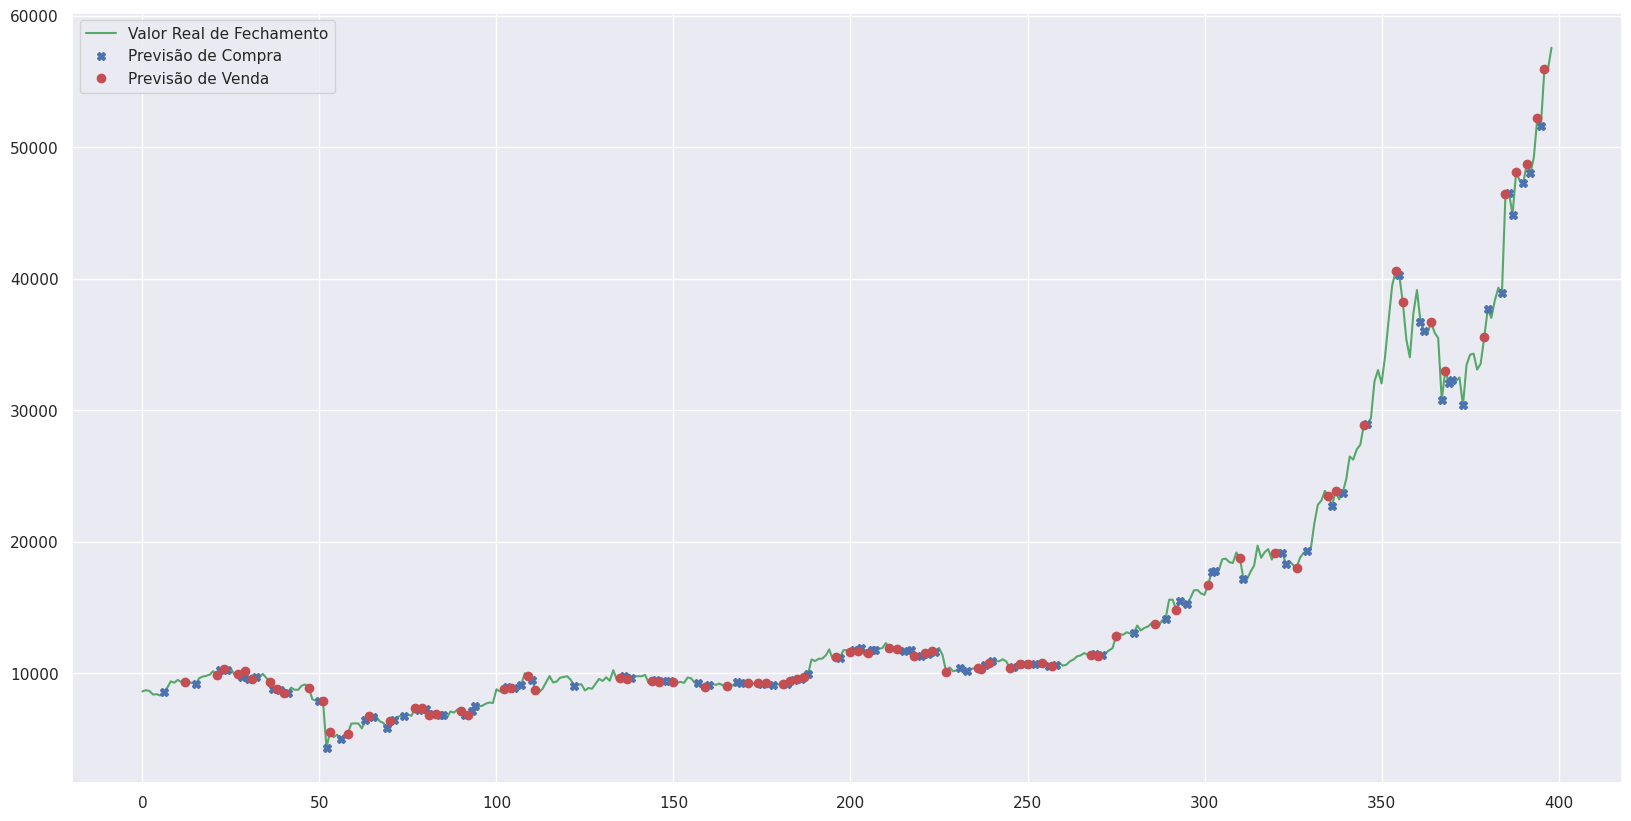

In [40]:
# Recomendações
trader_base.investir()

### Execução do AI Bot Trader - Modelo Otimizado

In [41]:
%%time
melhor_trader(window_size = int(np.around(max([d['window_size'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]))), 
              skip = int(np.around(max([d['skip'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]))), 
              population_size = int(max([d['population_size'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]])), 
              sigma = max([d['sigma'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]), 
              learning_rate = max([d['learning_rate'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]), 
              size_network = int(np.around(max([d['size_network'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]))))

Tempo Total de Treinamento: 15.90531849861145 segundos
CPU times: user 40.9 s, sys: 550 ms, total: 41.5 s
Wall time: 15.9 s


2118.75

In [42]:
%%time
modelo_otim = Modelo(input_size = int(np.around(max([d['window_size'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]))), 
                     layer_size = int(np.around(max([d['size_network'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]))), 
                     output_size = 3)

CPU times: user 2.22 ms, sys: 0 ns, total: 2.22 ms
Wall time: 1.6 ms


In [43]:
# Cria o trader com otimização
trader_otim = Trader(population_size = int(np.around(max([d['population_size'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]))), 
                     sigma = max([d['sigma'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]), 
                     learning_rate = max([d['learning_rate'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]), 
                     model = modelo_otim, 
                     money = 10000, 
                     max_buy = 5, 
                     max_sell = 5, 
                     skip = int(np.around(max([d['skip'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]))), 
                     window_size = int(np.around(max([d['window_size'] for d in [dic['params'] for dic in otimizacao_bayesiana.res]]))))

Aqui treinamos o trader!

In [44]:
%%time
trader_otim.fit(500, 100)

Iteração 100. Recompensa: 2331.975000
Iteração 200. Recompensa: 2435.525000
Iteração 300. Recompensa: 2435.525000
Iteração 400. Recompensa: 2435.525000
Iteração 500. Recompensa: 2435.525000
Tempo Total de Treinamento: 87.41865706443787 segundos
CPU times: user 3min 40s, sys: 3.12 s, total: 3min 43s
Wall time: 1min 27s


Dia 0: comprar 5 unidades ao preço de 43162.500000, saldo total -33162.500000
Dia 30, vender 5 unidades ao preço de 47982.500000, investimento 11.167101 %, saldo total 14820.000000,
Dia 60: comprar 5 unidades ao preço de 31020.000000, saldo total -16200.000000
Dia 120, vender 5 unidades ao preço de 48932.500000, investimento 57.745003 %, saldo total 32732.500000,
Dia 150: comprar 5 unidades ao preço de 46870.000000, saldo total -14137.500000
Dia 210, vender 5 unidades ao preço de 61542.500000, investimento 31.304672 %, saldo total 47405.000000,
Dia 240: comprar 5 unidades ao preço de 54747.500000, saldo total -7342.500000
Dia 360, vender 5 unidades ao preço de 195717.500000, investimento 257.491210 %, saldo total 188375.000000,
Dia 375: comprar 5 unidades ao preço de 171150.000000, saldo total 17225.000000
Dia 390, vender 5 unidades ao preço de 236327.500000, investimento 38.082092 %, saldo total 253552.500000,

Ganho Total 243552.500000, Valor Total Investido 2435.525000


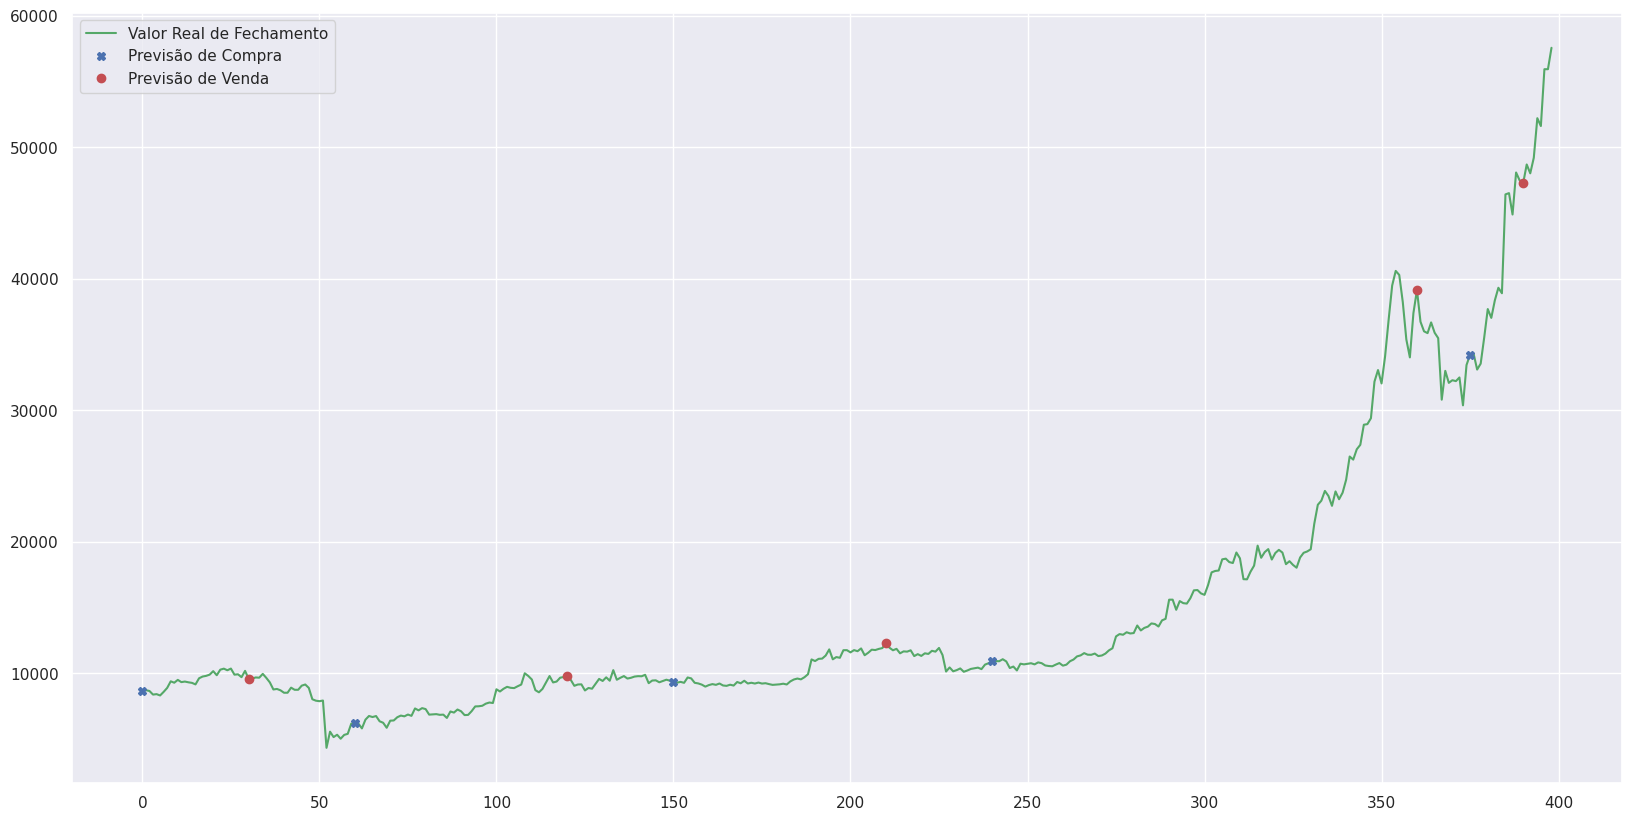

CPU times: user 288 ms, sys: 4.04 ms, total: 292 ms
Wall time: 240 ms


In [45]:
%%time
trader_otim.investir()

## Parte 5 - Conclusão, Lições Aprendidas e Próximos Passos

- Um projeto como esse é complexo e requer conhecimento avançado.
- Nosso Trader demonstrou bons resultados com baixo volume de dados. Teríamos que validar isso com volumes de dados maiores.
- Diferentes políticas podem ser usadas para treinar o Trader e essa é uma decisão humana.
- Diferentes arquiteturas podem ser usadas no modelo e essa é uma decisão humana.
- Todas as técnicas usadas neste projeto podem ser refinadas com procedimentos mais avançados, tornando o AI Bot Trader ainda mais preciso.

# Fim